In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pylab as plt
import copy

import sys
sys.path.append("..")

from fdfdpy import Simulation
from structures import three_port, two_port
from optimization import Optimization
from utils import Binarizer

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
lambda0 = 2e-6              # free space wavelength (m)
c0 = 3e8                    # speed of light in vacuum (m/s)
omega = 2*np.pi*c0/lambda0  # angular frequency (2pi/s)
dl = 0.8e-1                 # grid size (L0)
NPML = [15, 15]             # number of pml grid points on x and y borders
pol = 'Ez'                  # polarization (either 'Hz' or 'Ez')
source_amp = 1.6             # amplitude of modal source (A/L0^2?)

In [3]:
# material constants
n_index = 2.44              # refractive index
eps_m = n_index**2          # relative permittivity
chi3 = 4.1*1e-19            # Al2S3 from Boyd (m^2/V^2)
# max_ind_shift = 5.8e-3      # maximum allowed nonlinear refractive index shift (computed from damage threshold)

In [4]:
# geometric parameters
L = 8         # length of box (L0)
H = 5         # height of box (L0)
w = .3        # width of waveguides (L0)
d = H/2.44    # distance between waveguides (L0)
l = 4         # length of waveguide from PML to box (L0)
spc = 3       # space between box and PML (L0)

Computed a domain with 230 grids in x and 167 grids in y
The simulation has 25 grids per free space wavelength


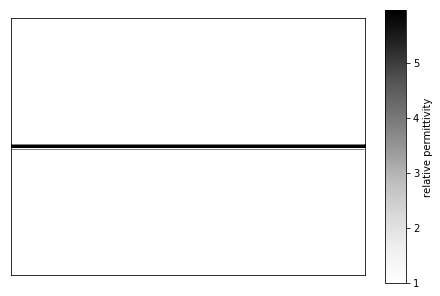

In [5]:
# define permittivity of three port system
eps_r, design_region = two_port(L, H, w, l, spc, dl, NPML, eps_m)
(Nx, Ny) = eps_r.shape
nx, ny = int(Nx/2), int(Ny/2)            # halfway grid points

simulation = Simulation(omega,eps_r,dl,NPML,pol)
# compute the grid size the total grid size
print("Computed a domain with {} grids in x and {} grids in y".format(Nx,Ny))
print("The simulation has {} grids per free space wavelength".format(int(lambda0/dl/simulation.L0)))
simulation.plt_eps()
plt.show()

In [6]:
# set the modal source and probes
simulation = Simulation(omega, eps_r, dl, NPML, 'Ez')
simulation.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny], int(H/2/dl), scale=source_amp)
simulation.setup_modes()

# top modal profile
out = Simulation(omega, eps_r, dl, NPML, 'Ez')
out.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny], int(H/2/dl))
out.setup_modes()
J_out = np.abs(out.src)

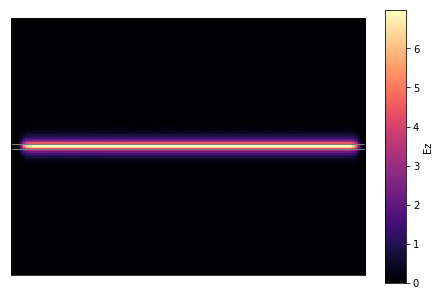

In [7]:
# set source and solve for electromagnetic fields
(_, _, Ez) = simulation.solve_fields()
simulation.plt_abs(outline=True, cbar=True);

In [8]:
# compute straight line simulation
eps_r_wg, _ = two_port(L, H, w, l, spc, dl, NPML, eps_start=eps_m)
(Nx_wg, Ny_wg) = eps_r_wg.shape
nx_wg, ny_wg = int(Nx_wg/2), int(Ny_wg/2)            # halfway grid points     
simulation_wg = Simulation(omega, eps_r_wg, dl, NPML, 'Ez')
simulation_wg.add_mode(np.sqrt(eps_m), 'x', [NPML[0]+int(l/2/dl), ny_wg], int(H/2/dl), scale=source_amp)
simulation_wg.setup_modes()

# compute normalization
sim_out = Simulation(omega, eps_r_wg, dl, NPML, 'Ez')
sim_out.add_mode(np.sqrt(eps_m), 'x', [-NPML[0]-int(l/2/dl), ny], int(H/2/dl))
sim_out.setup_modes()
J_out = np.abs(sim_out.src)
(_, _, Ez_wg) = simulation_wg.solve_fields()
SCALE = np.sum(np.square(np.abs(Ez_wg))*J_out)
print('computed a scale of {} in units of E^2 J_out'.format(SCALE))

computed a scale of 77.21267498779474 in units of E^2 J_out


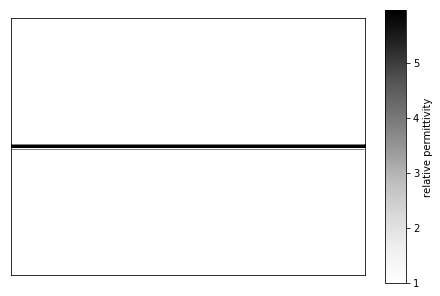

In [9]:
# changes design region. 'style' can be in {'full', 'empty', 'halfway', 'random'}
simulation.init_design_region(design_region, eps_m, style=None)
simulation.plt_eps()
plt.show()

In [10]:
# add nonlinearity
nl_region = copy.deepcopy(design_region)

simulation.nonlinearity = []  # This is needed in case you re-run this cell, for example (or you can re-initialize simulation every time)
simulation.add_nl(chi3, nl_region, eps_scale=True, eps_max=eps_m)

In [11]:
# define objective function
import autograd.numpy as npa
def J(e, e_nl, eps):
    """ objective function of BOOST means perfect separation between linear and nonlinear
        note: need BOOST if the objective function is too low (source amplitude is low).
        In this case LBFGS just converges and returns before it's actually done.
        Working on this.
    """
    BOOST = 1e7
    linear_out =     1*npa.sum(npa.square(npa.abs(e))*J_out)
    nonlinear_out = -1*npa.sum(npa.square(npa.abs(e_nl))*J_out)
    objfn = linear_out + nonlinear_out
    objfn_binary = objfn
    return objfn_binary / SCALE * BOOST

In [12]:
# make optimization object and check derivatives
optimization = Optimization(J=J, Nsteps=50, eps_max=eps_m, field_start='linear', nl_solver='newton')

# check the derivatives (note, full derivatives are checked, linear and nonlinear no longer separate)
(grad_avm, grad_num) = optimization.check_deriv(simulation, design_region, Npts=4)
print('adjoint gradient   = {}\nnumerical gradient = {}'.format(grad_avm, grad_num))

adjoint gradient   = [3.7669425758224406e-05, -0.0024235150035529784, -0.008314150894278782, 0.003888171692487674]
numerical gradient = [0.0001012265165023507, -0.0021846522670898594, -0.008587689535488607, 0.0034969160132014565]


In [13]:
# run the optimization with the simulation and the region and nonlinearity information
new_eps = optimization.run(simulation, design_region, method='lbfgs')
# new_eps = optimization.run(simulation, design_region, method='gd', step_size=1e3)
# new_eps = optimization.run(simulation, design_region, method='adam', step_size=1e-1, beta1=0.9, beta2=0.99)

 ObjectiveFn: 2.9e+06 Iteration:  49/50 ETA:   0:00:05                         

In [26]:
binarizer = Binarizer(design_region, eps_m)
J_bin = binarizer.density(J)
optimization.J = J_bin
optimization.Nsteps = 1000
new_eps = optimization.run(simulation, design_region, method='lbfgs')

 ObjectiveFn: 8.37e+06 Iteration:  230/1000 ETA:   1:27:20                     

KeyboardInterrupt: 

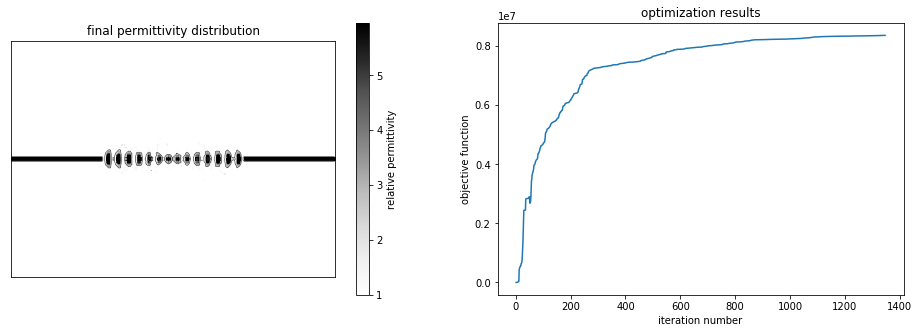

In [38]:
# plot optimization results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,5))

simulation.plt_eps(ax=ax1)
ax1.set_title('final permittivity distribution')

optimization.plt_objs(ax=ax2)
ax2.set_yscale('linear')
plt.show()

5.0
5.005050505050505
5.01010101010101
5.015151515151516
5.02020202020202
5.025252525252525
5.03030303030303
5.0353535353535355
5.040404040404041
5.045454545454546
5.05050505050505
5.055555555555555
5.0606060606060606
5.065656565656566
5.070707070707071
5.075757575757576
5.08080808080808
5.085858585858586
5.090909090909091
5.095959595959596
5.101010101010101
5.106060606060606
5.111111111111111
5.116161616161616
5.121212121212121
5.126262626262626
5.1313131313131315
5.136363636363637
5.141414141414142
5.146464646464646
5.151515151515151
5.156565656565657
5.161616161616162
5.166666666666667
5.171717171717172
5.1767676767676765
5.181818181818182
5.186868686868687
5.191919191919192
5.196969696969697
5.202020202020202
5.207070707070707
5.212121212121212
5.217171717171717
5.222222222222222
5.2272727272727275
5.232323232323233
5.237373737373737
5.242424242424242
5.247474747474747
5.252525252525253
5.257575757575758
5.262626262626263
5.267676767676767
5.2727272727272725
5.277777777777778
5.282

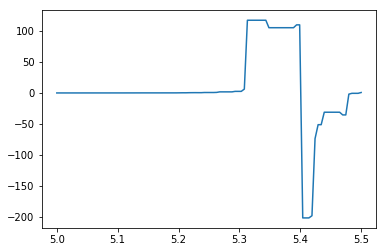

In [42]:
Nb = 100
Js = []
eps_range = np.linspace(5,5.5,Nb)
for e in eps_range:
    print(e)
    eps_test = copy.deepcopy(simulation.eps_r)
    eps_test[simulation.eps_r<e] = 1
    eps_test[simulation.eps_r>=e] = eps_m
    sim_test = copy.deepcopy(simulation)
    sim_test.eps_r = eps_test
    (_,_,Ez) = sim_test.solve_fields()
    (_,_,Ez_nl,_) = sim_test.solve_fields_nl()
    objfn = J(Ez, Ez_nl, eps_test)
    Js.append(objfn)
plt.plot(eps_range, Js)
plt.show()


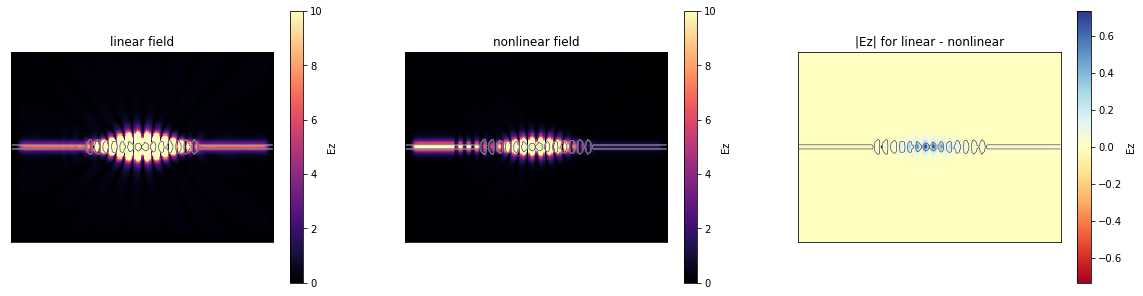

In [21]:
# compare the linear and nonlinear fields

# setup subplots
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))

# linear fields
(Hx,Hy,Ez) = simulation.solve_fields()
simulation.plt_abs(ax=ax1, vmax=10)
ax1.set_title('linear field')

# nonlinear fields
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()
simulation.plt_abs(ax=ax2, vmax=10, nl=True)
ax2.set_title('nonlinear field')

# difference
simulation.plt_diff(ax=ax3)
ax3.set_title('|Ez| for linear - nonlinear')

plt.show()

maximum refractive index shift of 0.0016133001107569989


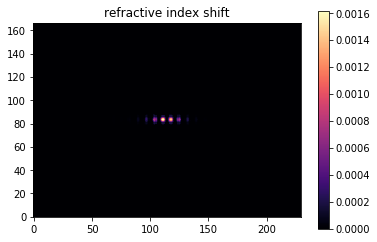

In [22]:
# compute the refractive index shift
index_shift = simulation.compute_index_shift()
print('maximum refractive index shift of {}'.format(np.max(index_shift)))
plt.imshow(index_shift.T, cmap='magma', origin='lower')
plt.colorbar()
plt.title('refractive index shift')
plt.show()

In [23]:
# compute powers

# input power
W_in = simulation.W_in

# linear powers
(Hx,Hy,Ez) = simulation.solve_fields()
W_out_lin = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny], int(Ny/2))
W_in_lin = simulation.flux_probe('x', [NPML[0]+int(2*l/3/dl), ny], int(Ny/2))

T_lin = W_out_lin/W_in

# nonlinear powers
(Hx_nl,Hy_nl,Ez_nl,_) = simulation.solve_fields_nl()
W_out_nl = simulation.flux_probe('x', [-NPML[0]-int(l/2/dl), ny], int(Ny/2))
W_in_nl = simulation.flux_probe('x', [NPML[0]+int(2*l/3/dl), ny], int(Ny/2))

T_nl = W_out_nl/W_in

print('linear transmission              = {:.4f}'.format(T_lin))
print('nonlinear transmission           = {:.4f}\n'.format(T_nl))
print('relative power difference        = {:.2f} %'.format(100*abs(W_out_lin-W_out_nl)/W_out_lin))
print('relative transmission difference = {:.2f} %'.format(100*abs(T_lin-T_nl)/T_lin))


linear transmission              = 0.9732
nonlinear transmission           = 0.9732

relative power difference        = 0.00 %
relative transmission difference = 0.00 %


 31% (62 of 200) |#######                | Elapsed Time: 0:03:27 ETA:   1:36:05

the simulation did not converge, reached 0.12335525360431093


100% (200 of 200) |######################| Elapsed Time: 0:14:29 ETA:  00:00:00

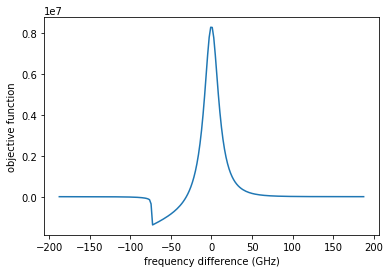

computed FWHM of 18.8442211053125 (GHz):
Q factor of 7.96E+03


In [24]:
freqs, objs, FWHM = optimization.scan_frequency(Nf=200, df=1/400)
optimization.simulation.omega = omega
plt.plot([(f-150e12)/1e9 for f in freqs], objs)
plt.xlabel('frequency difference (GHz)')
plt.ylabel('objective function')
plt.show()
print('computed FWHM of {} (GHz):'.format(FWHM/1e9))
print('Q factor of {0:.2E}'.format(omega/2/np.pi/FWHM))

In [25]:
np.save('../data/figs/data/2port_eps', simulation.eps_r)
np.save('../data/figs/data/2port_objfn_list', optimization.objfn_list)
np.save('../data/figs/data/2port_freqs', freqs)
np.save('../data/figs/data/2port_objs', objs)
